In [2]:
import sys
sys.path.append('..')
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import configparser
import os
from pathlib import Path
import json
# from scipy import interpolate

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot

config = configparser.ConfigParser()
config.read('../_system.ini')
results_dir = config['system_info']['alternate_location']

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

In [7]:
parent_folder = Path(results_dir,'experiment_nonlinear')
folder = '0808_2mode5-2894762'
# folder = 'unshuffle3-1157601'
# parent_folder = Path(results_dir,'train-on-time-coefficient')
# folder = 'no-regularisation'
folder_path = Path(parent_folder,folder)
filename = Path(folder_path,'training_param.ini')
nonlinear = TrainNN_from_config(filename)

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    u_test = np.array(hf.get('u_test'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

    u_test_mean = np.array(hf.get('u_avg_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.3952428


In [8]:
# data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
A_data = pod.get_time_coefficient
phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))

Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.


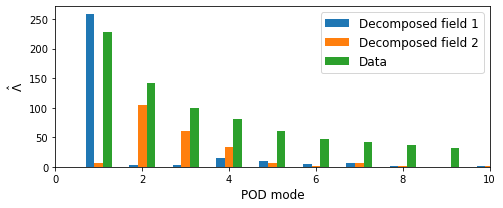

In [13]:
# reproject autoencoder modes onto data pod modes
lam_modes = mode_eval.equivalent_pca_energy(modes_train,Q_POD)
lam_modes_percent = lam_modes/lam_data
x_axis = np.arange(1,nonlinear.Nz*nonlinear.Ny*nonlinear.Nu+1)

fig, ax = plt.subplots(1,figsize=(7,3))
im1 = ax.bar(x_axis-0.2,lam_modes[0,:],0.2,label='Decomposed field 1')
im2 = ax.bar(x_axis,lam_modes[1,:],0.2,label='Decomposed field 2')
im3 = ax.bar(x_axis+0.2,lam_data,0.2,label='Data')
plt.legend(fontsize='large')
plt.xlabel('POD mode',fontsize='large')
plt.ylabel('$\hat{\Lambda}$',fontsize='large')
plt.tight_layout()
ax.set_xlim([0,10])
# fig.savefig('equivalent_energy.pdf')
plt.show()

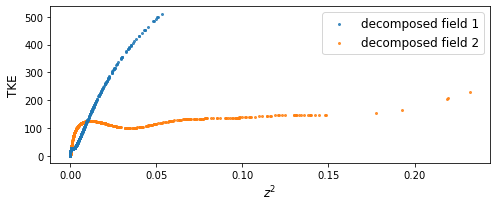

In [15]:
# Kinetic energy (tke)
ke = 0.5 * np.einsum('z t x y u -> z t', modes_test**2)

plt.figure(figsize=(7,3))
plt.scatter(latent_test[:,0]**2, ke[0,:], alpha=0.8,label='decomposed field 1',s=4,zorder=2)
plt.scatter(latent_test[:,1]**2, ke[1,:], alpha=0.8,label='decomposed field 2',s=4)
plt.xlabel('$z^2$',fontsize='large')
plt.ylabel('TKE',fontsize='large')
# plt.xlim([-0.01,0.15])
# plt.minorticks_on()
# plt.grid(which='both')
plt.tight_layout()
plt.legend(fontsize='large')
plt.savefig('tke.pdf')
plt.show()

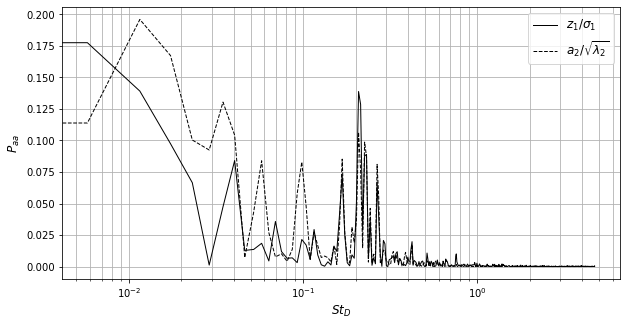

In [9]:
## get psd of latent variables
from matplotlib import mlab
which_z = 0
which_a = 1

Ntrain = 1632
D = 196.5
Uinf = 15

plt.figure(figsize=(10,5))
# latent
pxx, freqs = mlab.psd(latent_train[:,which_z]/(np.var(latent_train[:,which_z])**0.5),Fs=720.0,NFFT=Ntrain)
st = ((D/1000)/Uinf)*freqs
plt.semilogx(st,pxx,'k',label="$z_{%i}/\sigma_{%i}$"%(which_z+1,which_z+1),linewidth=1)
# time coeff
paa, freqs = mlab.psd(A_data[:,which_a]/(lam_data[which_a]**0.5),Fs=720.0,NFFT=Ntrain)
plt.semilogx(st,paa,'k--',label="$a_{%i}/\sqrt{\lambda_{%i}}$"%(which_a+1,which_a+1),linewidth=1)
plt.xlabel("$St_D$",fontsize='large')
plt.ylabel("$P_{aa}$",fontsize='large')
plt.grid(which='both')
plt.legend(fontsize='large')
plt.savefig('psd-of-z-unshuffled.pdf')
plt.show()

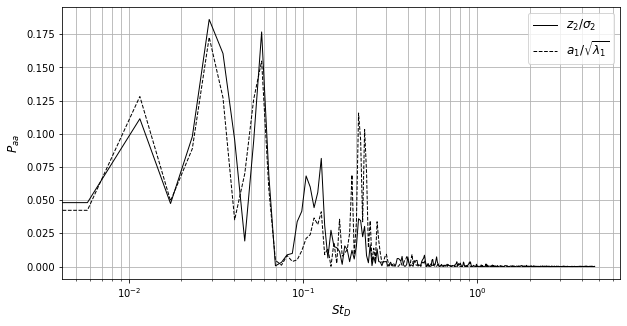

In [10]:
# compare PSD
which_z = 1
which_a = 0
plt.figure(figsize=(10,5))
# latent
pxx, freqs = mlab.psd(latent_train[:,which_z]/(np.var(latent_train[:,which_z])**0.5),Fs=720.0,NFFT=Ntrain)
st = ((D/1000)/Uinf)*freqs
plt.semilogx(st,pxx,'k',label="$z_{%i}/\sigma_{%i}$"%(which_z+1,which_z+1),linewidth=1)
# time coeff
paa, freqs = mlab.psd(A_data[:,which_a]/(lam_data[which_a]**0.5),Fs=720.0,NFFT=Ntrain)
plt.semilogx(st,paa,'k--',label="$a_{%i}/\sqrt{\lambda_{%i}}$"%(which_a+1,which_a+1),linewidth=1)
plt.xlabel("$St_D$",fontsize='large')
plt.ylabel("$P_{aa}$",fontsize='large')
plt.grid(which='both')
plt.legend(fontsize='large')
plt.savefig('psd-of-z-unshuffled2.pdf')
plt.show()

In [58]:
# Get shapes of decoder
mdl = mdl_nobias.MD_Autoencoder(Nx=nonlinear.Nx,Nu=nonlinear.Nu,
                            features_layers=nonlinear.features_layers,
                            latent_dim=nonlinear.latent_dim,
                            filter_window=nonlinear.filter_window,
                            act_fct=nonlinear.act_fct,
                            batch_norm=nonlinear.BATCH_NORM,
                            drop_rate=nonlinear.drop_rate,
                            lmb=nonlinear.lmb,
                            resize_meth=nonlinear.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=nonlinear.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
filename = Path(folder_path,'md_ae_model.h5')
mdl.load_weights(filename)
# ===============================================

mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

51/51 [==============================] - 3s 54ms/step - loss: 1.4174


1.4173568487167358

In [59]:
shape1 = mdl.get_decoders()[0].predict(np.array([1]).reshape(1,1))
shape2 = mdl.get_decoders()[1].predict(np.array([1]).reshape(1,1))

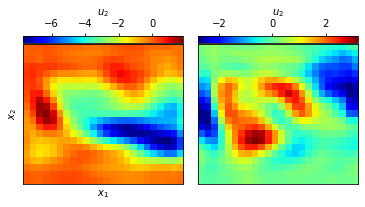

In [65]:
fig = plt.figure()
grid = ImageGrid(fig,111,nrows_ncols=(1,2),axes_pad=0.2,cbar_mode="each",cbar_location="top",cbar_pad=0.01,share_all=True)
im = grid[0].imshow(shape1[0,:,:,0],'jet')
grid.cbar_axes[0].colorbar(im,label='$u_2$')
grid[0].set_xticks([])
grid[0].set_yticks([])
grid[0].set_xlabel('$x_1$')
grid[0].set_ylabel('$x_2$')
im = grid[1].imshow(shape2[0,:,:,0],'jet')
grid.cbar_axes[1].colorbar(im,label='$u_2$')

# fig.savefig('shape_of_decoder.pdf')
plt.show()

# Appendix 

## Linear section

In [7]:
parent_folder = Path(results_dir, 'experiment_linear_samedata')
experiments = ['u_bias3-3598028','ufluc_bias14-853358','u_nobias6-249321','ufluc_nobias21-1438472']
loss_train_linear = []
loss_val_linear = []
for i in range(4):
    filename = Path(parent_folder,experiments[i],'results.h5')
    with h5py.File(filename,'r') as hf:
        loss_train_linear.append(np.array(hf.get('hist_train')))
        loss_val_linear.append(np.array(hf.get('hist_val')))

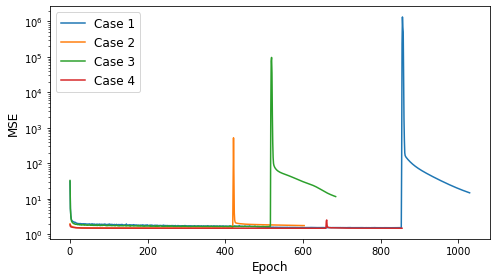

In [17]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.set_xlabel('Epoch',fontsize='large')
ax.set_ylabel('MSE',fontsize='large')
ax.semilogy(loss_train_linear[0],label='Case 1')
ax.semilogy(loss_train_linear[1],label='Case 2')
ax.semilogy(loss_train_linear[2],label='Case 3')
ax.semilogy(loss_train_linear[3],label='Case 4')
ax.legend(fontsize='large')
fig.tight_layout()
# fig.savefig('appendix_linear_training_curve.pdf')

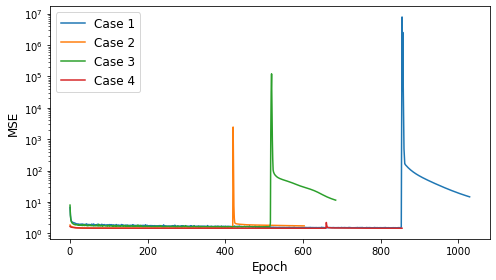

In [15]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.set_xlabel('Epoch',fontsize='large')
ax.set_ylabel('MSE',fontsize='large')
ax.semilogy(loss_val_linear[0],label='Case 1')
ax.semilogy(loss_val_linear[1],label='Case 2')
ax.semilogy(loss_val_linear[2],label='Case 3')
ax.semilogy(loss_val_linear[3],label='Case 4')
ax.legend(fontsize='large')
fig.tight_layout()
# fig.savefig('appendix_linear_training_curve_val.pdf')

## Nonlinear

In [19]:
parent_folder = Path(results_dir,'experiment_standard_nonlinear')

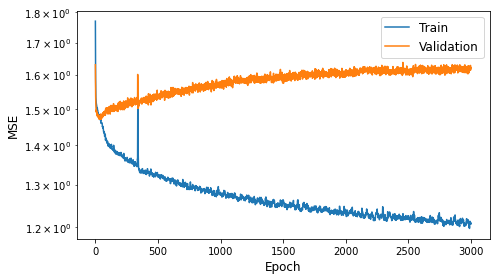

In [22]:
folder_path = Path(parent_folder,'2mode-regularised-1-764454')
filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    loss_train = np.array(hf.get('hist_train'))
    loss_val = np.array(hf.get('hist_val'))

fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.set_xlabel('Epoch',fontsize='large')
ax.set_ylabel('MSE',fontsize='large')
ax.semilogy(loss_train,label='Train')
ax.semilogy(loss_val,label='Validation')
ax.legend(fontsize='large')
fig.tight_layout()
# fig.savefig('appendix_nonlinear-standard-training-curve.pdf')
